In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
from getdist import plots, MCSamples

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
contours = [0.68,0.95]
linewidth = 2 

In [2]:
def prob_template_given_mag(fraction, kt, magnitude):
    """
    | Spectral type | Fraction | kt    |
    |---------------|----------|-------|
    | E/SO          | 0.35     | 0.147 |
    | Spirals       | 0.50     | 0.450 |
    | Irregulars    | 0.15     |       |
    """
    if magnitude>32.: magnitude = 32. + 1E-32
    if magnitude<20.: magnitude = 20. + 1E-32
        
    expterm = kt * (magnitude - 20.0)
    return fraction * np.exp(-expterm)

def prob_redshift_given_template_mag(redshift, magnitude, alpha, redshift_ref, kmt):
    """
    See table from Benitez (2000). 
    
    | Spectral type | alpha  | redshift reference | kmt    |
    |---------------|--------|--------------------|--------|
    | E/SO          | 2.465  | 0.431              | 0.0913 |
    | Spirals       | 1.806  | 0.390              | 0.0636 |
    | Irregulars    | 0.906  | 0.0626             | 0.123  |
    """
    if magnitude>32.: magnitude = 32. + 1E-32
    if magnitude<20.: magnitude = 20. + 1E-32

    zmt = redshift_ref + kmt * (magnitude - 20)
    probability = redshift**alpha * np.exp(- (redshift / zmt)**alpha)
    norm = np.trapz(probability, redshift)
    return probability / norm

def prob_redshift_given_mag(redshift, magnitude):

    p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
    p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
    p_temp_irr = 1 - (p_temp_eso + p_temp_spi)
        
    probability_eso = prob_redshift_given_template_mag(redshift, magnitude, 2.465, 0.431, 0.0913)
    probability_spi = prob_redshift_given_template_mag(redshift, magnitude, 1.806, 0.390, 0.0636)
    probability_irr = prob_redshift_given_template_mag(redshift, magnitude, 0.906, 0.0626, 0.123)

    probability = p_temp_eso * probability_eso + p_temp_spi * probability_spi + p_temp_irr * probability_irr
    probability = probability / np.trapz(probability, redshift)
    return probability

# Plot Distributions

In [3]:
# the fine bin for redshift 
z_grid_binsize = 0.001
z_grid_edges = np.arange(0.0, 3.0, z_grid_binsize)
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

# the magnitude
magnitude = 22.0 

In [4]:
p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
p_temp_irr = 1 - (p_temp_eso + p_temp_spi)

In [5]:
probability_eso = prob_redshift_given_template_mag(z_grid, 22, 2.465, 0.431, 0.0913)
probability_spi = prob_redshift_given_template_mag(z_grid, 22, 1.806, 0.390, 0.0636)
probability_irr = prob_redshift_given_template_mag(z_grid, 22, 0.906, 0.0626, 0.123)
prob_z_given_mag = prob_redshift_given_mag(z_grid, 22)

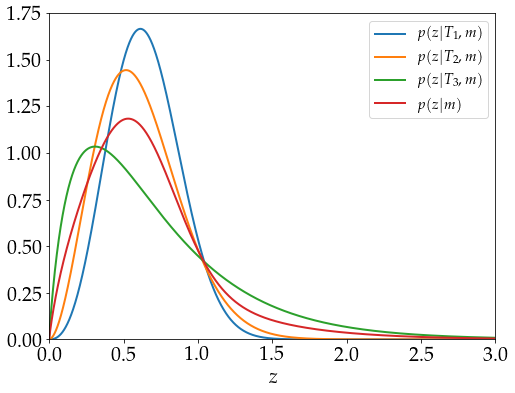

In [6]:
plt.figure(figsize = (8,6))
plt.plot(z_grid, probability_eso, lw = 2, label = r'$p(z|T_{1}, m)$')
plt.plot(z_grid, probability_spi, lw = 2, label = r'$p(z|T_{2}, m)$')
plt.plot(z_grid, probability_irr, lw = 2, label = r'$p(z|T_{3}, m)$')
plt.plot(z_grid, prob_z_given_mag, lw = 2, label = r'$p(z|m)$')
plt.xlim(min(z_grid)-0.001, max(z_grid)+0.002)
plt.ylim(0, 1.75)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

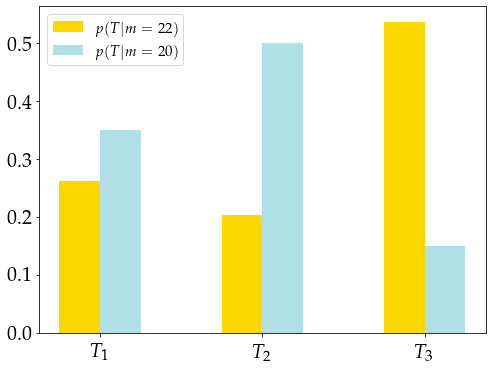

In [7]:
barWidth = 0.25
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(8,6))
plt.bar(br1, [p_temp_eso, p_temp_spi, p_temp_irr], width = barWidth, label = r'$p(T|m=22)$', color = 'gold')
plt.bar(br2, [0.35, 0.50, 0.15], width = barWidth, label = r'$p(T|m=20)$',  color = 'powderblue')
plt.xticks([r + 0.5*barWidth for r in range(3)], [r'$T_{1}$', r'$T_{2}$', r'$T_{3}$'])
plt.tick_params(axis='x', labelsize=fontSize, pad=10)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Filters

In [213]:
def interpolate_filters(folder: str, fnames: list, nwave: int=1000):
    filters = dict()
    filters_int = dict()
    record_min = list()
    record_max = list()
    for file in fnames:
        filterband = np.loadtxt(f'{folder}/{file}')[:,[0,1]]
        wavelength = filterband[:,0]
        record_min.append(min(wavelength))
        record_max.append(max(wavelength))
        filters[file.split('.')[0]] = filterband
        
    minwave = min(record_min)
    maxwave = max(record_max)
    waveint = np.linspace(minwave, maxwave, nwave)
    
    for key, value in filters.items():
        func = interp1d(value[:,0], value[:,1], bounds_error=False, kind='linear',
                        fill_value=(value[:,1][0], value[:,1][-1]))
        ynew = func(waveint)
        filters_int[key] = ynew
    filters_int['wavelength'] = waveint
    
    return filters_int

In [214]:
filternames = ['u.dat', 'g.dat', 'r.dat', 'i.dat', 'z.dat']
filters_int = interpolate_filters('filters', filternames, 1000)

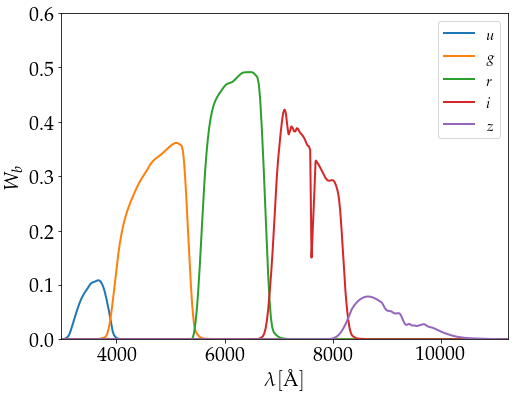

In [215]:
plt.figure(figsize = (8, 6))
plt.plot(filters_int['wavelength'], filters_int['u'], label = r'$u$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['g'], label = r'$g$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['r'], label = r'$r$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['i'], label = r'$i$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['z'], label = r'$z$', lw = 2)
plt.ylim(0.0, 0.6)
plt.xlim(min(filters_int['wavelength']), max(filters_int['wavelength']))
plt.xlabel(r'$\lambda [\textrm{\AA}]$', fontsize = fontSize)
plt.ylabel(r'$W_{b}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Templates

In [364]:
def process_templates(folder, waverange: list, nwave: int = 1000, normwave=7E3):
    """
    Process the templates in such a way that they are normalised at wavelength=7000 angstrom. They are 
    also interpolated in the range of the wavelength of the filters, that is, between 2980.0 and 11230.0. 
    """
    waveint = np.linspace(waverange[0], waverange[1], nwave)
    templates = dict()
    seds = os.listdir('seds/')
    for f in seds:
        file = np.loadtxt(f'seds/{f}')
        wavelength = file[:, 0]
        sed = file[:,1] * file[:,0]**2 / 3E18
        norm_constant = np.interp(normwave, wavelength, sed)
        sed = sed / norm_constant
        func = interp1d(wavelength, sed, bounds_error=False, kind='linear', fill_value=(sed[0], sed[-1]))
        ynew = func(waveint)
        templates[f.split('.')[0]] = ynew
    templates['wavelength'] = waveint
    return templates

In [365]:
# filenames for the templates 
template_fnames = os.listdir('seds/')
templatenames = [f.split('.')[0] for f in template_fnames]

# process templates 
waverange = (filters_int['wavelength'][0], filters_int['wavelength'][-1])
templates = process_templates('seds/', waverange, 1000, 4.5E3)

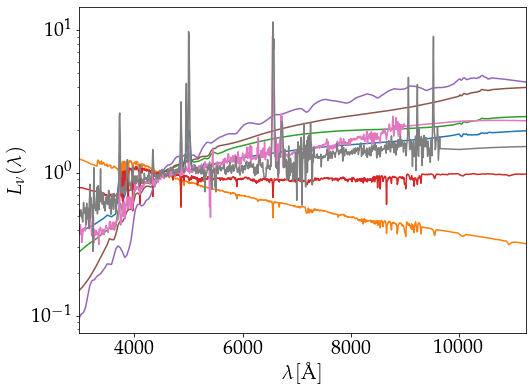

In [366]:
plt.figure(figsize=(8,6))
for fname in templatenames:
    plt.plot(templates['wavelength'], templates[fname])
plt.xlabel(r'$\lambda [\textrm{\AA}]$', fontsize = fontSize)
plt.ylabel(r'$L_{\nu}(\lambda)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(waverange[0], waverange[1])
plt.yscale('log')
plt.show()

# Example of Magnitude Distribution

In [14]:
def imagnitude_distribution(mgrid, alpha=15.0, beta = 2.0, maglim=24.0, offset = 1.0):
    probability = mgrid**alpha * np.exp(-(mgrid/(maglim - offset))**beta)
    normalisation = np.trapz(probability, mgrid)
    probability /= normalisation
    return probability 

def imagnitude_error_distribution(magnitudes, param_a = 4.56, param_b=1.0, param_k = 1.0, maglim=24.0, sigmadet = 5.0):
    teff = np.exp(param_a + param_b * (maglim - 21.0))
    flux = 10**(-0.4 * (magnitudes - 22.5))
    flim = 10**(-0.4 * (maglim-22.5))
    fnoise = (flim / sigmadet)**2 * param_k * teff - flim
    sigma_m = 2.5/np.log(10) * np.sqrt((1.0+fnoise/flux)/(flux * param_k * teff))
    return sigma_m


    a, b = 4.56, 1
    k = 1
    sigmadet = 5
    teff = np.exp(a + b * (mlim - 21.))
    F = 10**(-0.4*(m-22.5))
    Flim = 10**(-0.4*(mlim-22.5))
    Fnoise = (Flim/sigmadet)**2 * k * teff - Flim
    return 2.5/np.log(10) * np.sqrt( (1 + Fnoise/F) / (F*k*teff))


def draw_samples_one_dim(pdf, grid, nsamples):
    cdf = np.cumsum(pdf)
    cdf /= np.max(cdf)
    uniform = np.random.uniform(0, 1, nsamples)
    func = interp1d(cdf, grid, bounds_error=False)
    samples = func(uniform)
    return samples

def analytical_error_distribution(probability_imag, mgrid, maglim=24.0):
    detprob = np.copy(probability_imag)
    ind = (mgrid >= maglim - 0.4)
    detprob[ind] *= np.exp(-0.5*((mgrid[ind]- maglim + 0.4) / 0.2)**2)
    normalisation = np.trapz(detprob, mgrid)
    detprob /= normalisation
    return detprob

In [15]:
# grid for i magnitude
imag_grid = np.linspace(17, 26, num=1000)  

# distribution for the i magnitude.
p_imag = imagnitude_distribution(imag_grid)

In [16]:
# Large number of objects to be generated.
nobj = 100000
imags = draw_samples_one_dim(p_imag, imag_grid, nobj) # draw_mag(nobj, imag_grid, p_imag)
imagerrs = imagnitude_error_distribution(imags) # imag_err(imags, maglim) 
imagswitherr = imags + imagerrs*np.random.randn(nobj)

In [17]:
# Doing SNR cut - keep galaxies detected at 5 sigma only
ind = (1./imagerrs > 5.) 
imags_cut = imags[ind]
imagerrs_cut = imagerrs[ind]
imagswitherr_cut = imagswitherr[ind]

In [18]:
analytical_error = analytical_error_distribution(p_imag, imag_grid)

# Sample from $p(m_{i})$

In [19]:
NBINS = 30

Error distribution for the $i$ magnitude. 

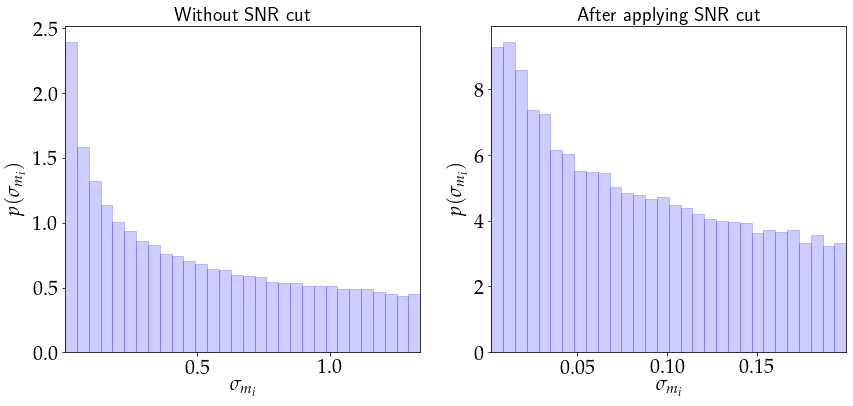

In [444]:
plt.figure(figsize = (14, 6))
plt.subplot(121)
plt.title('Without SNR cut', fontsize=fontSize)
plt.hist(imagerrs, density=True, bins=NBINS, edgecolor='b', color = 'b', alpha = 0.2)
plt.xlim(min(imagerrs), max(imagerrs))
plt.xlabel(r'$\sigma_{m_{i}}$', fontsize = fontSize)
plt.ylabel(r'$p(\sigma_{m_{i}})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)

plt.subplot(122)
plt.title('After applying SNR cut', fontsize=fontSize)
plt.hist(imagerrs_cut, density=True, bins=NBINS, edgecolor='b', color = 'b', alpha = 0.2)
plt.xlim(min(imagerrs_cut), max(imagerrs_cut))
plt.xlabel(r'$\sigma_{m_{i}}$', fontsize = fontSize)
plt.ylabel(r'$p(\sigma_{m_{i}})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

Distribution for the $m_{i}$, with/without cut-off (SNR). 

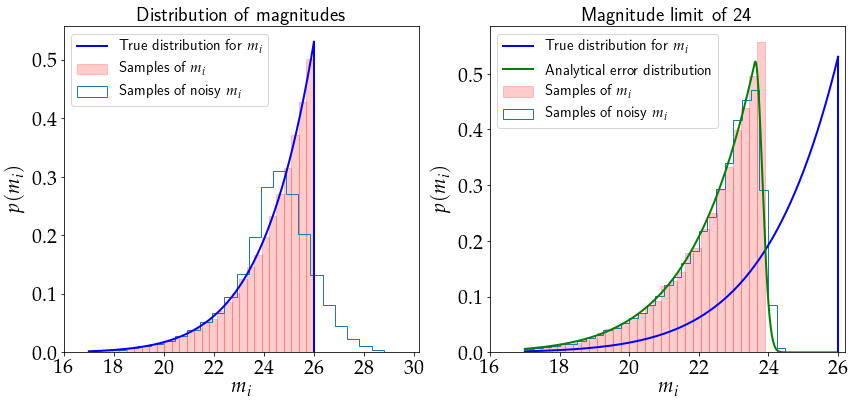

In [21]:
plt.figure(figsize = (14, 6))
plt.subplot(121)
plt.title('Distribution of magnitudes', fontsize=fontSize)
plt.plot(imag_grid, p_imag, lw = 2, c = 'b', label = 'True distribution for $m_{i}$')
plt.plot([imag_grid[-1]]*2, [0, p_imag[-1]], lw = 2, c = 'b')
plt.hist(imags, density = True, bins=NBINS, edgecolor='r', color = 'r', alpha = 0.2, label = 'Samples of $m_{i}$')
plt.hist(imagswitherr, density = True, histtype='step', bins=NBINS, label = 'Samples of noisy $m_{i}$')
plt.xlabel(r'$m_{i}$', fontsize = fontSize)
plt.ylabel(r'$p(m_{i})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xticks(np.arange(16, 30.2, 2))
plt.xlim(16, 30.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.subplot(122)
plt.title('Magnitude limit of 24', fontsize=fontSize)
plt.plot(imag_grid, p_imag, lw = 2, c = 'b', label = 'True distribution for $m_{i}$')
plt.plot(imag_grid, analytical_error, lw = 2, c = 'g', label = 'Analytical error distribution')
plt.plot([imag_grid[-1]]*2, [0, p_imag[-1]], lw = 2, c = 'b')
plt.hist(imags_cut, density = True, bins=NBINS, edgecolor='r', color = 'r', alpha = 0.2, label = 'Samples of $m_{i}$')
plt.hist(imagswitherr_cut, density = True, histtype='step', bins=NBINS, label = 'Samples of noisy $m_{i}$')
plt.xlabel(r'$m_{i}$', fontsize = fontSize)
plt.ylabel(r'$p(m_{i})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xticks(np.arange(16, 26.2, 2))
plt.xlim(16, 26.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Sample redshift

In [22]:
def pdf_redshift(magnitude_samples, redshift, template_ref: str = 'eso'):
    
    assert template_ref in ['eso', 'spi', 'irr', 'marg'], 'template reference should be one of eso, spi, irr, marg'
    
    if template_ref == 'eso':
        pdf = prob_redshift_given_template_mag(redshift, magnitude_samples, 2.465, 0.431, 0.0913)
    elif template_ref == 'spi':
        pdf = prob_redshift_given_template_mag(redshift, magnitude_samples, 1.806, 0.390, 0.0636)
    elif template_ref == 'irr':
        pdf = prob_redshift_given_template_mag(redshift, magnitude_samples, 0.906, 0.0626, 0.123)
    else:
        pdf = prob_redshift_given_mag(redshift, magnitude_samples)
    return pdf

def sample_redshift(magnitude_samples, redshift, template_ref: str = 'eso'):
    pdf = pdf_redshift(magnitude_samples, redshift, template_ref)
    sample = draw_samples_one_dim(pdf, redshift, 1)
    return sample

In [23]:
nobj_cut = 10000 # len(imags_cut)

In [24]:
%%time
redshift_eso = np.array([pdf_redshift(imags_cut[i], z_grid, 'eso') for i in range(nobj_cut)])
redshift_spi = np.array([pdf_redshift(imags_cut[i], z_grid, 'spi') for i in range(nobj_cut)])
redshift_irr = np.array([pdf_redshift(imags_cut[i], z_grid, 'irr') for i in range(nobj_cut)])
redshift_marg = np.array([pdf_redshift(imags_cut[i], z_grid, 'marg') for i in range(nobj_cut)])

CPU times: user 7.81 s, sys: 88.6 ms, total: 7.9 s
Wall time: 7.9 s


In [25]:
%%time
sample_redshift_eso = np.array([sample_redshift(imags_cut[0], z_grid, 'eso') for i in range(nobj_cut)]).reshape(-1)
sample_redshift_spi = np.array([sample_redshift(imags_cut[0], z_grid, 'spi') for i in range(nobj_cut)]).reshape(-1)
sample_redshift_irr = np.array([sample_redshift(imags_cut[0], z_grid, 'irr') for i in range(nobj_cut)]).reshape(-1)
sample_redshift_marg = np.array([sample_redshift(imags_cut[0], z_grid, 'marg') for i in range(nobj_cut)]).reshape(-1)

CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 11.5 s


In [28]:
data_eso = np.array([sample_redshift_eso, imags_cut[0:nobj_cut]]).T
data_spi = np.array([sample_redshift_spi, imags_cut[0:nobj_cut]]).T
data_irr = np.array([sample_redshift_irr, imags_cut[0:nobj_cut]]).T
data_marg = np.array([sample_redshift_marg, imags_cut[0:nobj_cut]]).T

In [125]:
def generate_2d_plot(samples, name = 'E/SO'):
    ndim = samples.shape[1]
    names = ["x%s"%i for i in range(ndim)]
    labels =  [r'$z$', r'$m_{i}$']
    samps = MCSamples(samples=samples, names = names, labels = labels, ranges={'x0':(0.0, None)}, settings=settings) 
    samps.updateSettings({'contours': [0.68, 0.95, 0.99]})
    
    ax = plots.get_single_plotter(width_inch=4, ratio=1)
    ax.settings.axes_fontsize=15
    ax.settings.lab_fontsize = 15
    ax.settings.num_plot_contours = 3
    ax.settings.solid_contour_palefactor = 0.75
    ax.settings.alpha_filled_add = 0.9
    ax.plot_2d(samps, 'x0', 'x1', filled=True, colors=['red'], lims=[0.0, 4.0, 16, 26])
    ax.add_legend([name], colored_text=True, legend_loc='lower right');
    return ax

In [143]:
def plot_all_samples(data_eso, data_spi, data_irr, data_marg):
    newsamples = np.concatenate([data_eso, data_spi, data_irr, data_marg], axis = 1)
    
    limits = {'x0':(0.0, None), 'x1':(16, 26),
              'x2':(0.0, None), 'x3':(16, 26),
              'x4':(0.0, None), 'x5':(16, 26),
              'x6':(0.0, None), 'x7':(16, 26)}
    
    ndim = 8
    names = ["x%s"%i for i in range(ndim)]
    labels =  [r'$z$', r'$m_{i}$']*4
    samps = MCSamples(samples=newsamples, names = names, labels = labels, ranges=limits, settings=settings)
    
    g = plots.get_subplot_plotter(subplot_size=4)
    g.settings.axes_fontsize=15
    g.settings.lab_fontsize = 15
    g.settings.num_plot_contours = 3
    g.settings.solid_contour_palefactor = 0.75
    g.settings.alpha_filled_add = 0.9
    g.settings.scaling = False # prevent scaling down font sizes even though small subplots
    g.plots_2d(samps, param_pairs=[['x0', 'x1'], ['x2', 'x3'], ['x4', 'x5'], ['x6', 'x7']], nx=2, filled=True, colors=['red'], lims=[0.0, 4.0, 16, 26]);
    plt.show()

In [166]:
def plot_1d_redshift_distributions(redshift_grid, pdfs, nselected):
    plt.figure(figsize = (12,8))
    plt.subplot(221)
    plt.title('E/SO', fontsize = fontSize)
    plt.plot(redshift_grid, pdfs[0][0:nselected].T, lw = 0.1)
    plt.xlabel(r'$z$', fontsize = fontSize)
    plt.ylabel(r'$p(z|T_{1}, m)$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.xlim(0, 3.0)
    plt.ylim(0, 2.5)
    
    plt.subplot(222)
    plt.title('Spirals', fontsize = fontSize)
    plt.plot(redshift_grid, pdfs[1][0:nselected].T, lw = 0.1)
    plt.xlabel(r'$z$', fontsize = fontSize)
    plt.ylabel(r'$p(z|T_{2}, m)$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.xlim(0, 3.0)
    plt.ylim(0, 2.0)
    
    plt.subplot(223)
    plt.title('Irregulars', fontsize = fontSize)
    plt.plot(redshift_grid, pdfs[2][0:nselected].T, lw = 0.1)
    plt.xlabel(r'$z$', fontsize = fontSize)
    plt.ylabel(r'$p(z|T_{3}, m)$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.xlim(0, 3.0)
    plt.ylim(0, 6.0)
    
    plt.subplot(224)
    plt.title('Marginalised over templates', fontsize = fontSize)
    plt.plot(redshift_grid, pdfs[3][0:nselected].T, lw = 0.1)
    plt.xlabel(r'$z$', fontsize = fontSize)
    plt.ylabel(r'$p(z|m)$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.xlim(0, 3.0)
    plt.ylim(0, 2.0)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.45)
    plt.show()

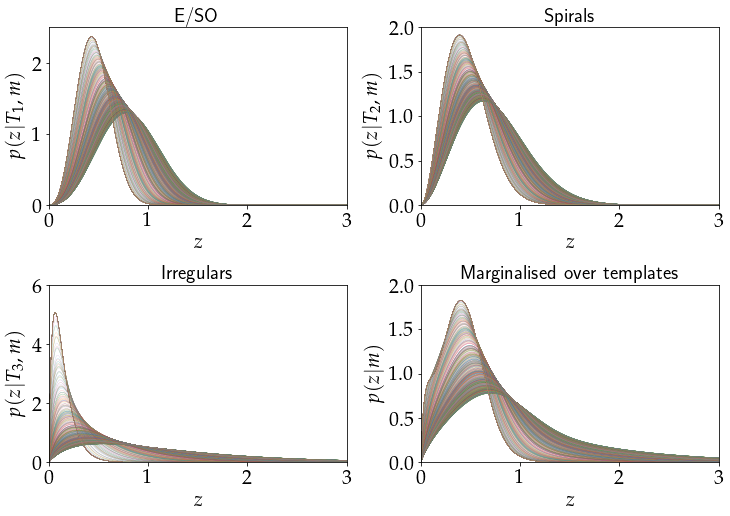

In [167]:
plot_1d_redshift_distributions(z_grid, [redshift_eso, redshift_spi, redshift_irr, redshift_marg], nselected=1000)

Removed no burn in


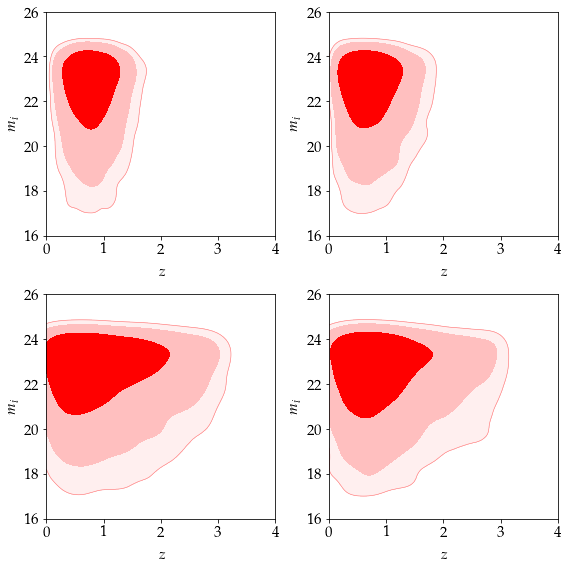

In [144]:
plot_all_samples(data_eso, data_spi, data_irr, data_marg)

# Use SEDs now

In [271]:
def approx_lum_dist(redshift):
    return np.exp(30.5 * redshift**0.04 - 21.7)

In [385]:
def get_seds(folder, waveref = 4E5):
    
    sednames = os.listdir(folder)
    seds = dict()
    for i, t in enumerate(sednames):
        seddata = np.genfromtxt(f'{folder}/{t}')
        seddata[:, 1] *= seddata[:, 0]**2. / 3e18
        ref = np.interp(waveref, seddata[:, 0], seddata[:, 1])
        seddata[:, 1] /= ref
        seds[t.split('.')[0]] = seddata
    return seds

In [408]:
def get_filters(folder):
    
    filters = os.listdir(folder)
    record = dict()
    record_wavelength = dict()
    record_minmax = dict()
    
    for f in filters:
        data = np.genfromtxt(f'{folder}/{f}')
        wavelength, filt = data[:, 0], data[:, 1]
        filt /= wavelength
        norm = np.trapz(filt, wavelength)
        filt /= norm
        
        # find minimum and maximum wavelength
        ind = np.where(filt > 0.01*np.max(filt))[0]
        lambda_min, lambda_max = wavelength[ind[0]], wavelength[ind[-1]]
        
        record[f.split('.')[0]] = filt
        record_minmax[f.split('.')[0]] = [lambda_min, lambda_max]
        record_wavelength[f.split('.')[0]] = wavelength
        
    return record, record_wavelength, record_minmax

In [464]:
def get_flux(filters, wavelengths, lambdaminmax, seds, redshift):
    
    scaled_redshift = 1.0 + redshift 
    nfilters = len(filters)
    nseds = len(seds)
    
    # calculate pre-factor 
    lum_dist = approx_lum_dist(redshift)
    prefactor = scaled_redshift**2 / (4.0 * np.pi * lum_dist**2)
    
    # empty array to store the fluxes 
    record_fluxes = dict()
    
    for i,s in enumerate(seds):
        fluxes = np.zeros(nfilters)
        for j,f in enumerate(filters):
            wave_grid = np.linspace(lambdaminmax[f][0]/scaled_redshift, lambdaminmax[f][1]/scaled_redshift, 5000)
            filter_interp = interp1d(wavelengths[f] / scaled_redshift, filters[f])
            sed_interp = interp1d(seds[s][:,0], seds[s][:,1])
            
            filter_new = filter_interp(wave_grid)
            sed_new = sed_interp(wave_grid)
            
            fluxes[j] = prefactor * np.trapz(sed_new * filter_new, wave_grid)
            
        record_fluxes[s] = fluxes
        
    record_fluxes = pd.DataFrame(record_fluxes).T
    record_fluxes.columns = filters.keys()
    return record_fluxes

In [465]:
get_flux(filters, filterwave, filterwaverange, seds, 0.002)

,u,g,r,i,z
Im_B2004a,0.000443,0.000839,0.001013,0.001179,0.001307
ssp_5Myr_z008,3.136324,2.656979,1.884955,1.505155,1.203167
Scd_B2004a,0.000396,0.000958,0.001455,0.001742,0.001861
ssp_25Myr_z008,0.282421,0.364836,0.340093,0.339375,0.347663
El_B2004a,0.000540,0.002433,0.004920,0.006855,0.008548
Sbc_B2004a,0.000228,0.000696,0.001189,0.001557,0.001902
SB3_B2004a,0.001392,0.002947,0.004321,0.004602,0.006109
SB2_B2004a,0.003199,0.005256,0.005833,0.005733,0.006731


In [423]:
seds = get_seds('seds')
filters, filterwave, filterwaverange = get_filters('filters')

In [675]:
%%time
fluxgrid = list()
ntest = len(z_grid)
for i in range(ntest):
    fluxcalc = get_flux(filters, filterwave, filterwaverange, seds, z_grid[i])
    fluxgrid.append(np.clip(-2.5 * np.log10(fluxcalc), 1E-5, 1E5))
fluxgrid = np.dstack(fluxgrid)

CPU times: user 33.2 s, sys: 1.27 ms, total: 33.2 s
Wall time: 33.2 s


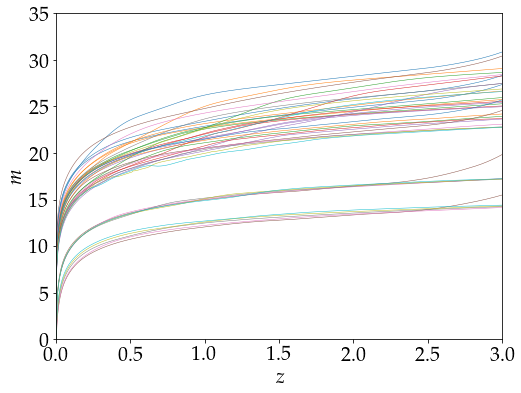

In [766]:
plt.figure(figsize = (8, 6))
nseds = len(seds)
nfilters = len(filters)
for i in range(nseds):
    for j in range(nfilters):
        sedtype = list(seds.keys())[i]
        filtertype = list(filters.keys())[j]
        plt.plot(z_grid, fluxgrid[i, j], lw=0.5)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.ylabel(r'$m$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(0, 3.0)
plt.ylim(0, 35)
plt.show()

In [474]:
def sample_mag_sigma(p_imag, imag_grid):
    sigmalevel = 1E-32
    while sigmalevel < 5:
        mag = draw_samples_one_dim(p_imag, imag_grid, 1)
        err = imagnitude_error_distribution(mag)
        sigmalevel = 1 / err
    return mag, err

In [552]:
def sample_template(magnitude, template_match):
    
    counts = dict(Counter([value[1] for value in template_match.items()]))
    
    p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
    p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
    p_temp_irr = 1 - (p_temp_eso + p_temp_spi)
    probabilities = {'eso': p_temp_eso/counts['eso'],
                     'spi': p_temp_spi/counts['spi'],
                     'irr': p_temp_irr/counts['irr']}
    
    probs = dict()
    for key in template_match.keys():
        if template_match[key] == 'eso':
            probs[key] = probabilities['eso']
        elif template_match[key] == 'spi':
            probs[key] = probabilities['spi']
        else:
            probs[key] = probabilities['irr']
    
    probabilities = np.asarray(list(probs.values())).reshape(-1)
    temp_samp = np.random.choice(list(probs.keys()), p = probabilities)
            
    return temp_samp, template_match[temp_samp]

In [553]:
template_match = {
    'El_B2004a': 'eso', 
    'Sbc_B2004a': 'spi',
    'Scd_B2004a': 'spi',
    'Im_B2004a': 'irr',
    'SB3_B2004a': 'irr',
    'SB2_B2004a': 'irr',
    'ssp_25Myr_z008': 'irr',
    'ssp_5Myr_z008': 'irr'
}

In [672]:
def generate_flux_redshift(p_imag, imag_grid, z_grid, template_match, nobjects):

    record = list()
    record_redshift = list()
    for i in range(nobjects):
        
        # get the magnitude and magnitude error 
        mag, magerr = sample_mag_sigma(p_imag, imag_grid)
        
        # sample the template
        template_sample = sample_template(mag, template_match)
        
        # sample the redshift
        redshift_sample = sample_redshift(mag, z_grid, template_sample[1])
        
        # get a sample of the flux 
        flux_sample = get_flux(filters, filterwave, filterwaverange, seds, redshift_sample[0])
        
        # calculate the magnitude (no error)
        mag_noerr = -2.5 * np.log10(flux_sample.divide(flux_sample['g'], axis = 0)) + mag[0]

        # calculate the error on the magnitude
        err = magerr * (1 + 0.05*np.random.randn(flux_sample.shape[1]))
        
        # calculate a noisy magnitude
        mag_err = mag_noerr.loc[template_sample[0]] + err * np.random.randn(flux_sample.shape[1])

        record.append(mag_err)
        record_redshift.append(redshift_sample)
        
    record = pd.DataFrame(record)
    record_redshift = np.asarray(record_redshift)
    return record, record_redshift

In [673]:
%%time
noisy_fluxes, redshift_samples = generate_flux_redshift(p_imag, imag_grid, z_grid, template_match, 5000)

CPU times: user 56.6 s, sys: 18.6 ms, total: 56.6 s
Wall time: 56.6 s


In [674]:
record_redshift = np.asarray(record_redshift)

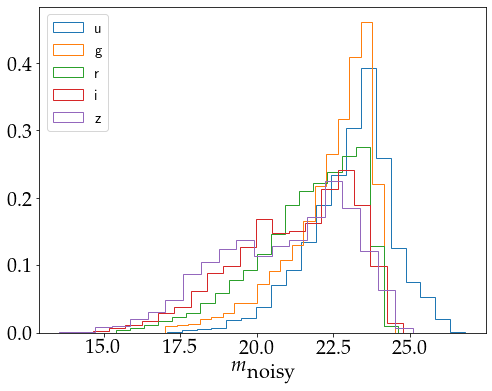

In [689]:
plt.figure(figsize = (8, 6))
plt.hist(noisy_fluxes['u'], density = True, bins = 20, histtype='step', label = 'u')
plt.hist(noisy_fluxes['g'], density = True, bins = 20, histtype='step', label = 'g')
plt.hist(noisy_fluxes['r'], density = True, bins = 20, histtype='step', label = 'r')
plt.hist(noisy_fluxes['i'], density = True, bins = 20, histtype='step', label = 'i')
plt.hist(noisy_fluxes['z'], density = True, bins = 20, histtype='step', label = 'z')
plt.xlabel(r'$m_{\textrm{noisy}}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Plot difference in Colors

In [744]:
temp_chosen = 'Sbc_B2004a'
index = df.index == temp_chosen
subset = df[index]
fluxgrid_sub = fluxgrid[list(seds.keys()).index(temp_chosen), :, :,]

In [745]:
keys = ['u', 'g', 'r', 'i', 'z']

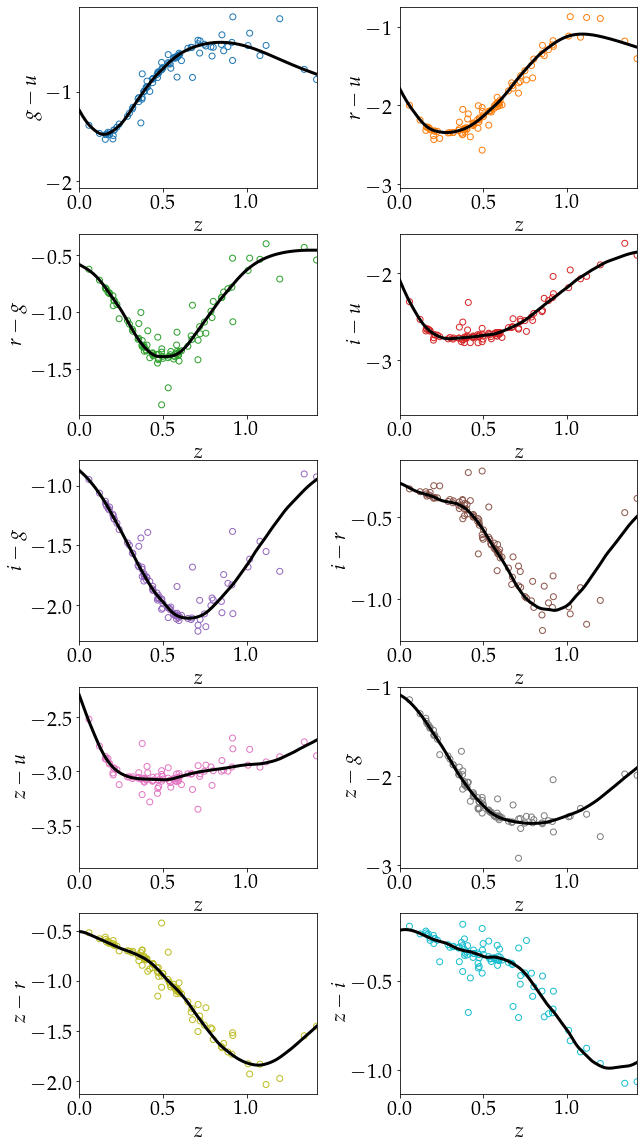

In [746]:
record_pairs = dict()
plt.figure(figsize = (10, 20))
iterindex = 0 
for j in range(5):
    for k in range(j+1):
        key1, key2 = keys[j], keys[k]
        if key1 != key2:
            delta = subset[key1].values - subset[key2].values
            fobs = fluxgrid_sub[j] - fluxgrid_sub[k]
            plt.subplot(5, 2, iterindex + 1)
            color = np.asarray(cm.tab10.colors[iterindex]).reshape(1,-1)
            plt.scatter(record_redshift[index], delta, color='none', edgecolors= color)
            plt.plot(z_grid, fobs, lw = 3, c = 'k')
            plt.xlim(0, max(record_redshift[index]))
            plt.ylabel(f'${key1} - {key2}$', fontsize = fontSize)
            plt.xlabel(r'$z$', fontsize = fontSize)
            plt.tick_params(axis='x', labelsize=fontSize)
            plt.tick_params(axis='y', labelsize=fontSize)
            iterindex += 1
            record_pairs[f'{key1}-{key2}'] = delta
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.25)
plt.show()

In [747]:
list(record_pairs.keys())

['g-u', 'r-u', 'r-g', 'i-u', 'i-g', 'i-r', 'z-u', 'z-g', 'z-r', 'z-i']

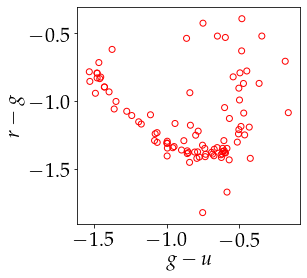

In [750]:
# g-r, u-g
plt.figure(figsize=(4,4))
plt.scatter(record_pairs['g-u'], record_pairs['r-g'], color='none', edgecolors= 'r')
plt.xlabel(r'$g-u$', fontsize = fontSize)
plt.ylabel(r'$r-g$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()